# A Hierarchical model for Rugby prediction
* @Author: Peadar Coyle
* @email: peadarcoyle@googlemail.com
* @date: 31/12/15 updated 29/12/2017

I came across the following blog post on [Daniel Weitzenfeld's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) blog, based on the work of [Baio and Blangiardo](http://discovery.ucl.ac.uk/16040/1/16040.pdf).

In this example, we're going to reproduce the first model described in the paper using PyMC3.

Since I am a rugby fan I decide to apply the results of the paper to the Six Nations Championship, which is a competition between Italy, Ireland, Scotland, England, France and Wales.

## Motivation
Your estimate of the strength of a team depends on your estimates of the other strengths

Ireland are a stronger team than Italy for example - but by how much?

Source for Results 2014 are Wikipedia. I've added the subsequent years, 2015, 2016, 2017. Manually pulled from Wikipedia. 

* We want to infer a latent parameter - that is the 'strength' of a team based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team. 
* Probabilistic Programming is a brilliant paradigm for modeling these **latent** parameters
* Aim is to build a model for the upcoming Six Nations in 2018.

In [1]:
!date

import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline


Sat Jan 13 16:41:34 UTC 2018


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This is a Rugby prediction exercise. So we'll input some data. We've taken this from Wikipedia and BBC sports. 

In [2]:
try:
    df_all = pd.read_csv('../data/rugby.csv')
except:
    df_all = pd.read_csv(pm.get_data('rugby.csv'))


## What do we want to infer?

* We want to infer the latent paremeters (every team's strength) that are generating the data we observe (the scorelines).
* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.
* Often we don't know what the Bayesian Model is explicitly, so we have to 'estimate' the Bayesian Model'
* If we can't solve something, approximate it.
* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.
* Fortunately, this algorithm can be applied to almost any model.

## What do we want?

* We want to quantify our uncertainty
* We want to also use this to generate a model
* We want the answers as distributions not point estimates

### Visualization/EDA
We should do some some exploratory data analysis of this dataset. 

The plots should be fairly self-explantory, we'll look at things like difference between teams in terms of their scores. 


In [3]:
df_all.describe()

,Unnamed: 0,home_score,away_score,year
count,60.000000,60.000000,60.000000,60.000000
mean,29.500000,23.500000,19.983333,2015.500000
std,17.464249,14.019962,12.911028,1.127469
min,0.000000,0.000000,0.000000,2014.000000
25%,14.750000,16.000000,10.000000,2014.750000
50%,29.500000,20.500000,18.000000,2015.500000
75%,44.250000,27.250000,23.250000,2016.250000
max,59.000000,67.000000,63.000000,2017.000000


In [4]:
# Let's look at the tail end of this dataframe
df_all.tail()

,Unnamed: 0,home_team,away_team,home_score,away_score,year
55,55,Italy,France,18,40,2017
56,56,England,Scotland,61,21,2017
57,57,Scotland,Italy,29,0,2017
58,58,France,Wales,20,18,2017
59,59,Ireland,England,13,9,2017


There are a few things here that we don't need. We don't need the year for our model. 
But that is something that could improve a future model. 

Firstly let us look at differences in scores by year. 

In [5]:
df_all['difference'] = np.abs(df_all['home_score']-df_all['away_score'])

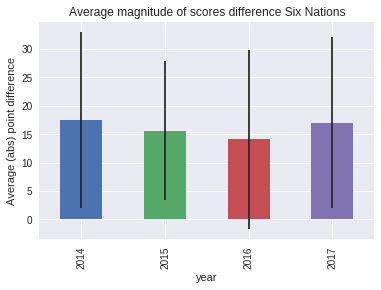

In [6]:
(df_all.groupby('year')['difference']
      .mean()
      
      .plot(kind='bar', title='Average magnitude of scores difference Six Nations', yerr=df_all.groupby('year')['difference'].std())
      .set_ylabel('Average (abs) point difference'));
                                                 


We can see that the standard error is large. So we can't say anything about the differences.
Let's look country by country. 

In [7]:
df_all['difference_non_abs']=df_all['home_score']-df_all['away_score']

Let us first loook at a Pivot table with a sum of this, broken down by year.

In [8]:
df_all.pivot_table('difference_non_abs', 'home_team', 'year')

year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


Now let's first plot this by home team without year. 

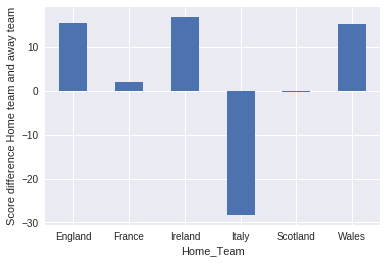

In [9]:
(df_all.pivot_table('difference_non_abs', 'home_team')
      .rename_axis("Home_Team")
      .plot(kind='bar', rot=0, legend=False)
      .set_ylabel('Score difference Home team and away team')
);


You can see that Italy and Scotland have negative scores on average. You can also see that England, Ireland and Wales have been the strongest teams lately at home. 

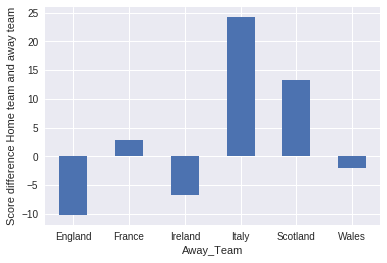

In [10]:
(df_all.pivot_table('difference_non_abs', 'away_team')
      .rename_axis("Away_Team")
      .plot(kind='bar', rot=0, legend=False)
      .set_ylabel('Score difference Home team and away team')
);


This indicates that Italy, Scotland and France all have poor away from home form. 
England suffers the least when playing away from home. This aggregate view doesn't take into account the strength of the teams. 

Let us look a bit more at a timeseries plot of the average of the score difference over the year. 

We see some changes in team behaviour, and we also see that Italy is a poor team. 

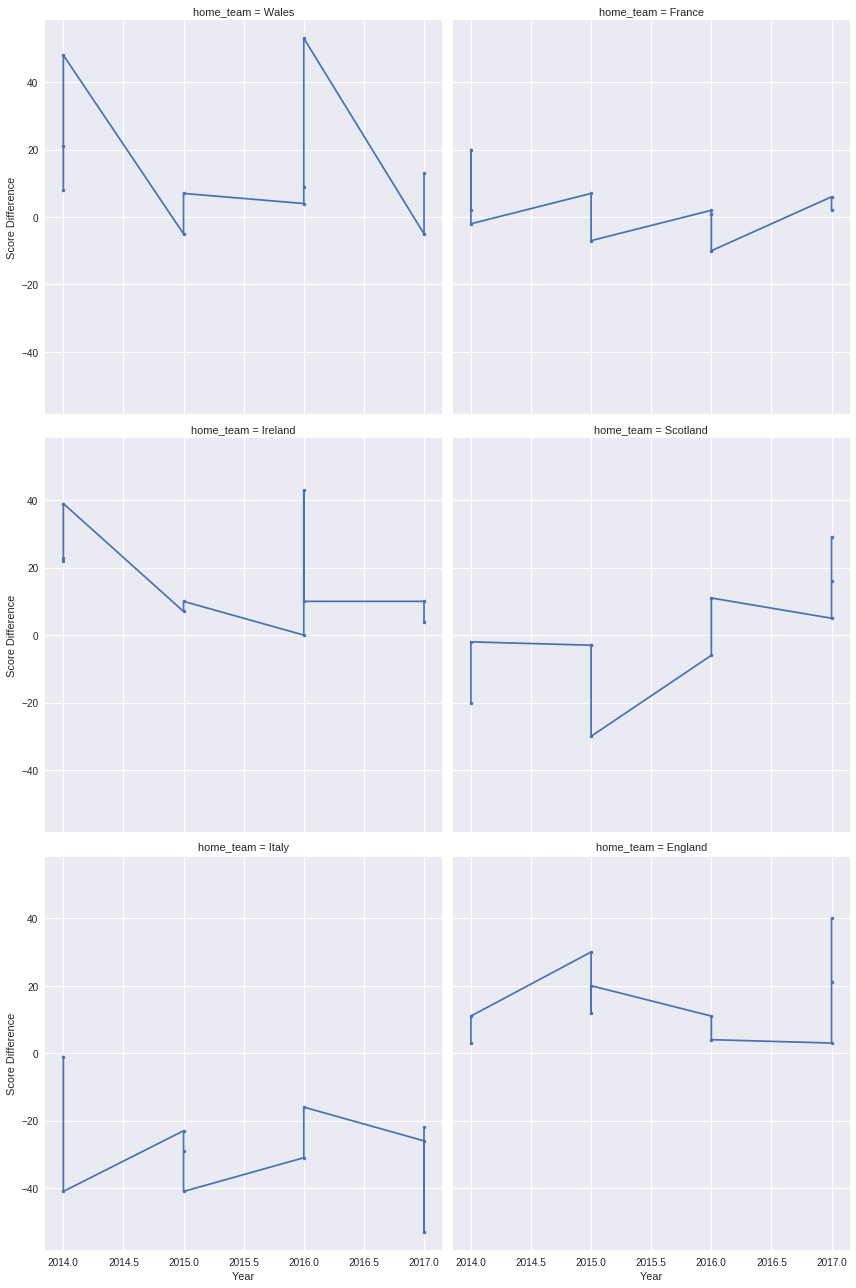

In [11]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, size=6)
g = g.map(plt.plot, "year", "difference_non_abs", marker=".").set_axis_labels("Year", "Score Difference")

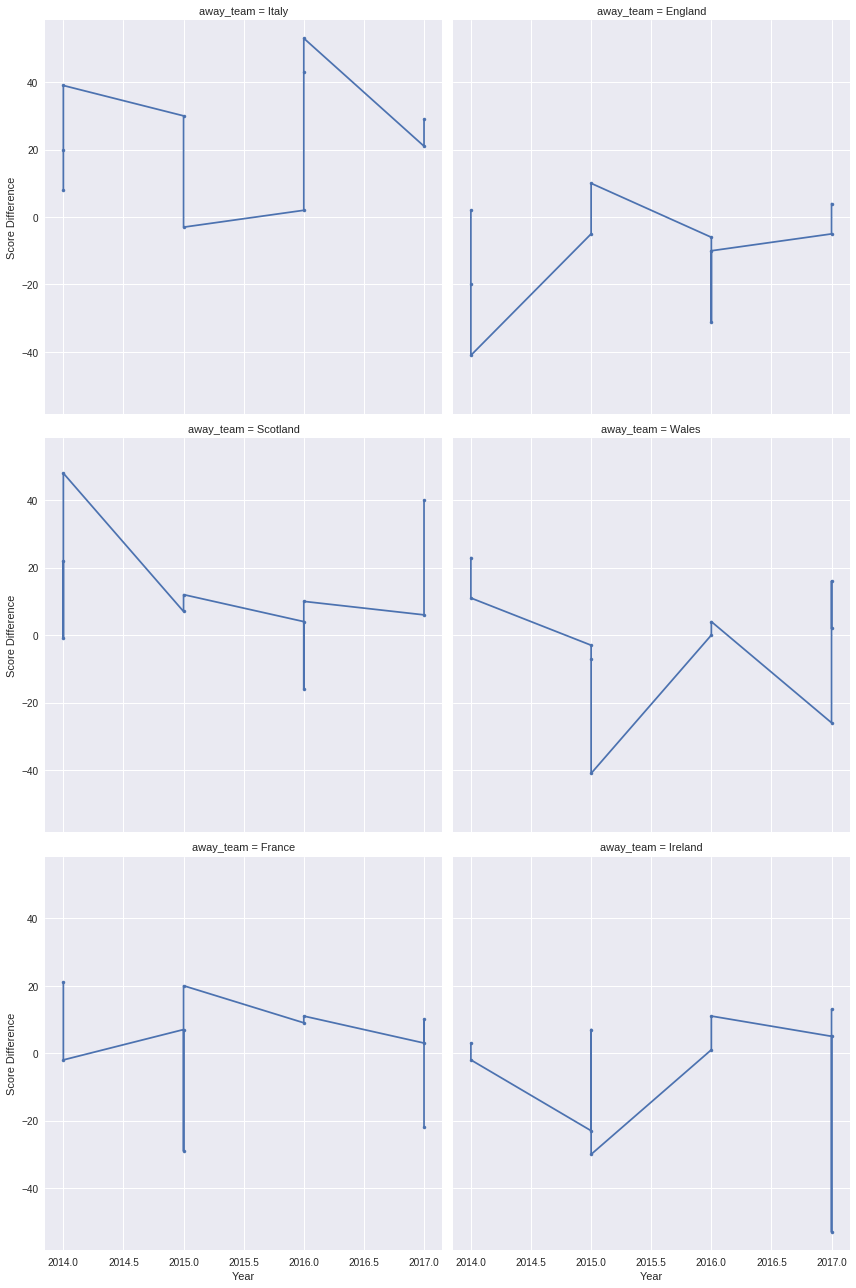

In [12]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, size=6)
g = g.map(plt.plot, "year", "difference_non_abs", marker=".").set_axis_labels("Year", "Score Difference")

You can see some interesting things here like Wales were good away from home in 2015. 
In that year they won three games away from home and won by 40 points or so away from home to Italy. 

So now we've got a feel for the data, we can proceed on with describing the model.

### What assumptions do we know for our 'generative story'?

* We know that the Six Nations in Rugby only has 6 teams - they each play each other once
* We have data from the last few years
* We also know that in sports scoring is modelled as a Poisson distribution
* We consider home advantage to be a strong effect in sports

## The model.

The league is made up by a total of T= 6 teams, playing each other once 
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
$y_{gi}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$
where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>


We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$


* The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
* The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

* Conversely, for each t = 1, ..., T, the team-specific effects are modelled as exchangeable from a common distribution:

* $att_{t} \; \tilde\;\; Normal(\mu_{att},\tau_{att})$ and $def_{t} \; \tilde\;\;Normal(\mu_{def},\tau_{def})$

We restrict to only the useful columns for this model.

In [13]:
df = df_all[['home_team', 'away_team', 'home_score', 'away_score']]

In [14]:
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

* We did some munging above and adjustments of the data to make it **tidier** for our model. 
* The log function to away scores and home scores is a standard trick in the sports analytics literature

## Building of the model 
* We now build the model in PyMC3, specifying the global parameters, and the team-specific parameters and the likelihood function 


In [15]:
with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')
    
    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)
 
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

* We specified the model and the likelihood function

* All this runs on a Theano graph under the hood

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def_log__, sd_att_log__, home]
100%|██████████| 2000/2000 [00:29<00:00, 68.07it/s]


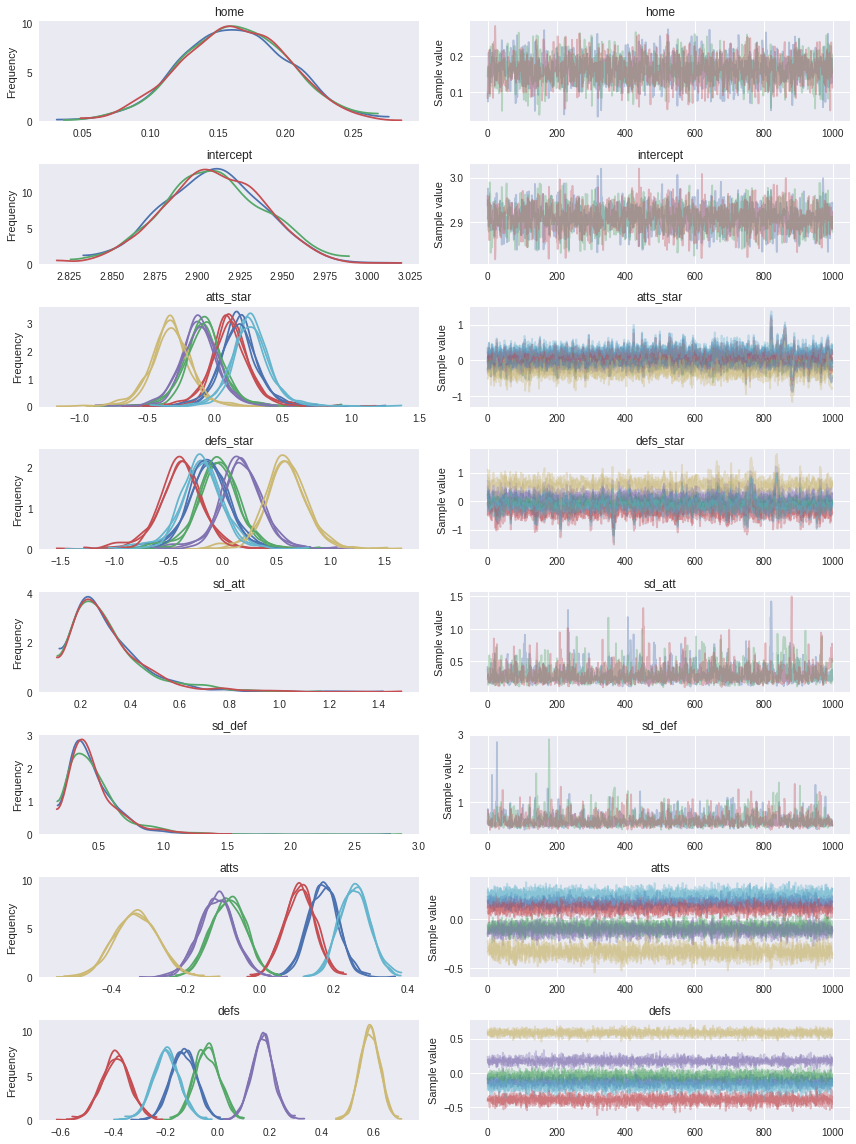

In [16]:
with model:
    trace = pm.sample(1000, tune=1000, cores=3)
    pm.traceplot(trace)

Let us apply good *statistical workflow* practices and look at the various evaluation metrics to see if our NUTS sampler converged.

In [17]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

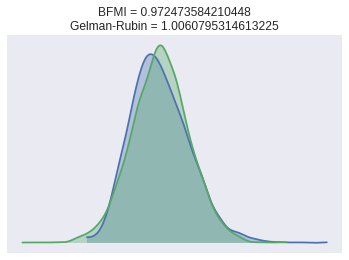

In [18]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

Our model has converged well and the Gelman-Rubin statistic looks good. 

Let us look at some of the stats, just to verify that our model has returned the correct attributes. We can see that some teams are stronger than others. This is what we would expect with attack

In [19]:
pm.stats.hpd(trace['atts'])

array([[ 0.08968587,  0.24789199],
       [-0.17169411,  0.00788836],
       [ 0.02725114,  0.18826695],
       [-0.20606871, -0.02168828],
       [-0.44769868, -0.22706935],
       [ 0.1813111 ,  0.34262147]])

In [20]:
pm.stats.quantiles(trace['atts'])[50]

array([ 0.17179028, -0.08393033,  0.10807495, -0.115689  , -0.33455323,
        0.25632191])

## Results
From the above we can start to understand the different distributions of attacking strength and defensive strength.
These are probabilistic estimates and help us better understand the uncertainty in sports analytics

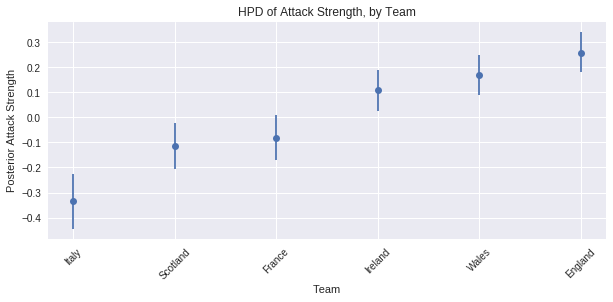

In [21]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']), 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

This is one of the powerful things about Bayesian modelling, we can have *uncertainty quantification* of some of our estimates. 
We've got a Bayesian credible interval for the attack strength of different countries. 

We can see an overlap between Ireland, Wales and England which is what you'd expect since these teams have won in recent years.

Italy is well behind everyone else - which is what we'd expect and there's an overlap between Scotland and France which seems about right.

There are probably some effects we'd like to add in here, like weighting more recent results more strongly. 
However that'd be a much more complicated model.

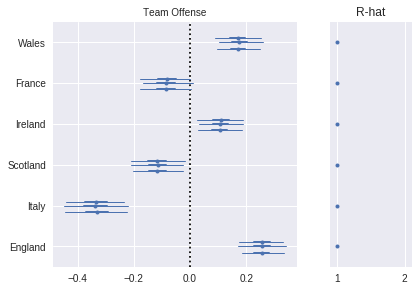

In [22]:
labels = teams.team.values
pm.forestplot(trace, varnames=['atts'], ylabels=labels, main="Team Offense")

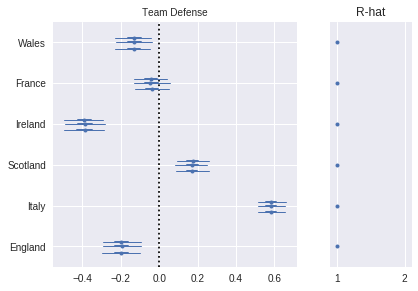

In [23]:
pm.forestplot(trace, varnames=['defs'], ylabels=labels, main="Team Defense")

Good teams like Ireland and England have a strong negative effect defense. Which is what we expect. We expect our strong teams to have strong positive effects in attack and strong negative effects in defense. 

This approach that we're using of looking at parameters and examining them is part of a good statistical workflow. 
We also think that perhaps our priors could be better specified. However this is beyond the scope of this article. 
We recommend for a good discussion of 'statistical workflow' you visit [Robust Statistical Workflow with RStan](http://mc-stan.org/users/documentation/case-studies/rstan_workflow.html)

Let's do some other plots. So we can see our range for our defensive effect. 
I'll print the teams below too just for reference

In [24]:
teams

,team,i
0,Wales,0
1,France,1
2,Ireland,2
3,Scotland,3
4,Italy,4
5,England,5


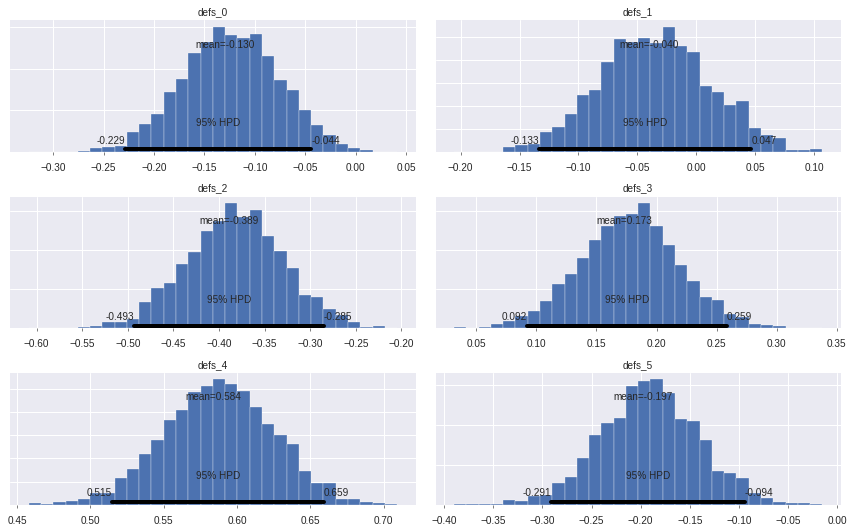

In [25]:
pm.plot_posterior(trace, varnames=['defs']);

We know Ireland is defs_2 so let's talk about that one. We can see that it's mean is -0.39 
which means we expect Ireland to have a strong defense. Which is what we'd expect, Ireland generally even in games it loses doesn't lose by say 50 points.
And we can see that the 95% HPD is between -0.491, and -0.28  

In comparison with Italy, we see a strong positive effect 0.58 mean and a HPD of 0.51 and 0.65. This means that we'd expect Italy to concede a lot of points, compared to what it scores. 
Given that Italy often loses by 30 - 60 points, this seems correct. 

We see here also that this informs what other priors we could bring into this. We could bring some sort of world ranking as a prior. 

As of December 2017 the [rugby rankings](https://www.worldrugby.org/rankings/mru) indicate that England is 2nd in the world, Ireland 3rd, Scotland 5th, Wales 7th, France 9th and Italy 14th. We could bring that into a model and it can explain some of the fact that Italy is apart from a lot of the other teams. 

Now let's simulate who wins over 1000 seasons.

In [26]:
with model:
    pp_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:01<00:00, 823.05it/s]


In [28]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
home_sim_df.insert(0, 'team', df['home_team'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
away_sim_df.insert(0, 'team', df['away_team'])

In [30]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [31]:
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0
team,,,,,,
England,0.464,0.428,0.108,0.000,0.000,0.000
France,0.000,0.002,0.029,0.912,0.057,0.000
Ireland,0.627,0.293,0.079,0.001,0.000,0.000
Italy,0.000,0.000,0.000,0.000,0.002,0.998
Scotland,0.000,0.000,0.000,0.127,0.873,0.000
Wales,0.077,0.255,0.658,0.010,0.000,0.000


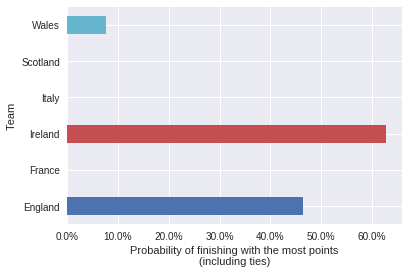

In [32]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n(including ties)");

ax.set_ylabel("Team");

We see according to this model that Ireland finishes with the most points about 60% of the time, and England finishes with the most points 45% of the time and Wales finishes with the most points about 10% of the time.  (Note that these probabilities do not sum to 100% since there is a non-zero chance of a tie atop the table.)
As an Irish rugby fan - I like this model. However it indicates some problems with shrinkage, and bias. Since recent form suggests England will win. 
Nevertheless the point of this model was to illustrate how a Hierachical model could be applied to a sports analytics problem, and illustrate the power of PyMC3. 

## Covariates
We should do some exploration of the variables

In [33]:
df_trace = pm.trace_to_dataframe(trace)

In [34]:
teams.team.values

array(['Wales', 'France', 'Ireland', 'Scotland', 'Italy', 'England'],
      dtype=object)

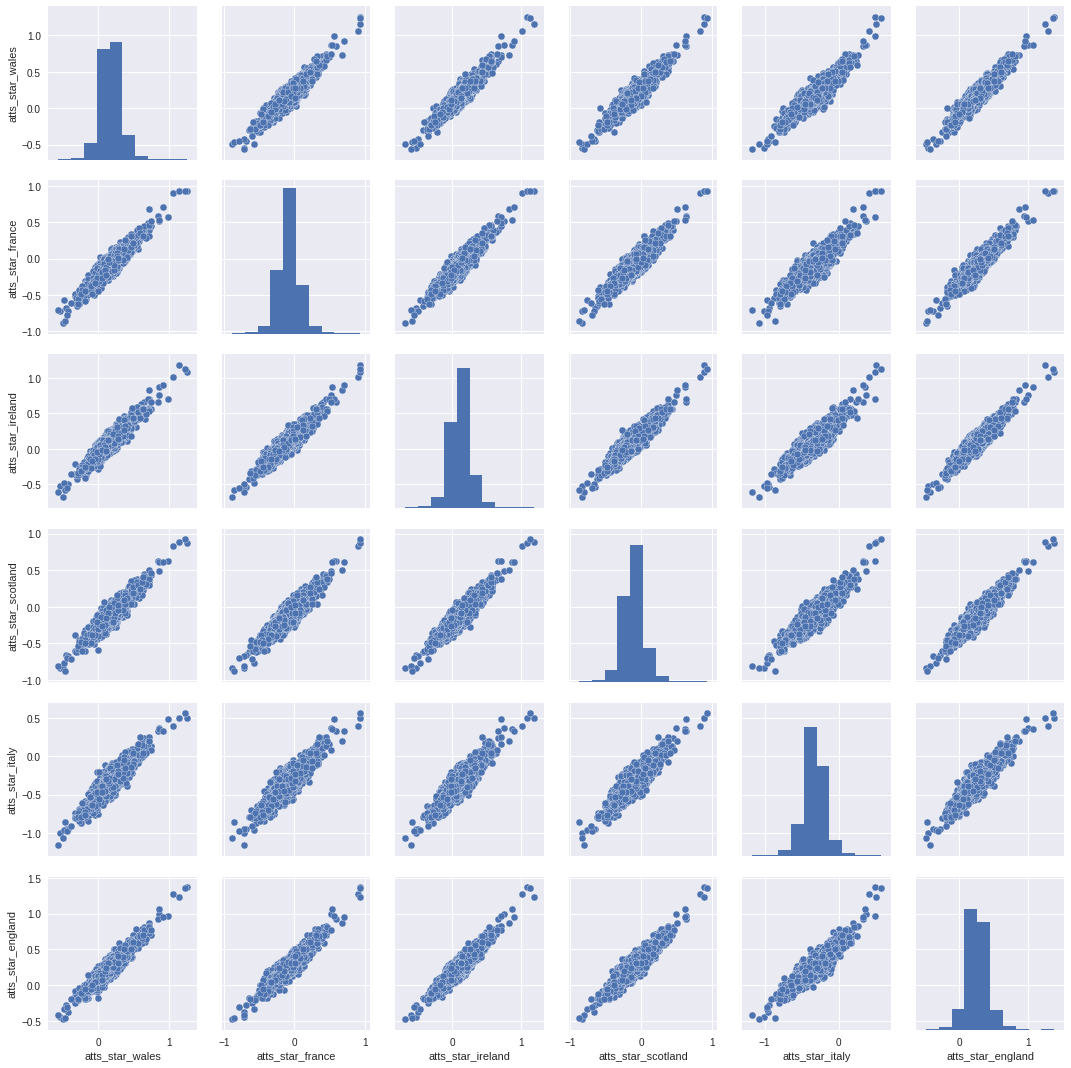

In [35]:
import seaborn as sns

cols = {
    'atts_star__0': 'atts_star_wales',
    'atts_star__1': 'atts_star_france',
    'atts_star__2': 'atts_star_ireland',
    'atts_star__3': 'atts_star_scotland',
    'atts_star__4': 'atts_star_italy',
    'atts_star__5': 'atts_star_england'
}

df_trace_att = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_att)

We observe that there isn't a lot of correlation between these covariates, other than the weaker teams like Italy have a more negative distribution of these variables. 
Nevertheless this is a good method to get some insight into how the variables are behaving. 